In [2]:
import h5py
import dxchange
import numpy as np
import torch as tc
import torch.nn.functional as F
import tomopy
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from unet_parts import *

## Load projections around a certain angle

In [15]:
_, _, _, theta = dxchange.read_aps_32id('raw/tomo_00001.h5', proj=(0, 1))
n_proj_rad = 5
n_skip = 100
i_theta_cen = len(theta) // 2
prj_ind_range = (i_theta_cen - n_skip * n_proj_rad, i_theta_cen + n_skip * n_proj_rad + 1, n_skip)
prj, flt, drk, theta = dxchange.read_aps_32id('raw/tomo_00001.h5', proj=prj_ind_range)
prj = tomopy.normalize(prj, flt, drk)
prj = tomopy.minus_log(prj)
theta_center = theta[i_theta_cen]
this_theta_ls = theta[slice(*prj_ind_range)]
this_theta_ls = this_theta_ls - theta_center
print(this_theta_ls)

# downsample
prj = zoom(prj, [1, 0.25, 0.25])
print(prj.shape)

[-1.04719755 -0.83775804 -0.62831853 -0.41887902 -0.20943951  0.
  0.20943951  0.41887902  0.62831853  0.83775804  1.04719755]
(11, 448, 512)


## Stretch projection images

In [16]:
def to_numpy(var):
    if var.device.type == 'cpu':
        return var.data.numpy()
    else:
        return var.cpu().data.numpy()

def rescale(x, scale_factor):
    a = tc.tensor([[[1. / scale_factor[1], 0, 0],
                    [0, 1./ scale_factor[0], 0]]])
    a = tcf.affine_grid(a, [1, 1, *prj.shape[1:]])
    try:
        x = tcf.grid_sample(x.reshape([1, 1, *x.shape]), a.double(), align_corners=True, padding_mode='border')
    except:
        x = tcf.grid_sample(x.reshape([1, 1, *x.shape]), a, align_corners=True, padding_mode='border')
    return x[0, 0]

def total_variation(arr, axis_offset=0):
    """
    Calculate total variation of a 3D array.
    :param arr: 3D Tensor.
    :return: Scalar.
    """
    arr_size = 1
    for i in range(len(arr.shape)):
        arr_size = arr_size * arr.shape[i]
    res = tc.sum(tc.abs(tc.roll(arr, 1, dims=0 + axis_offset) - arr))
    res = res + tc.sum(tc.abs(w.roll(arr, 1, dims=1 + axis_offset) - arr))
    res = res / arr_size
    return res

In [17]:
device = None
prj_trans = np.zeros_like(prj)
for i in range(len(this_theta_ls)):
    x = prj[i]
    x = tc.tensor(x, requires_grad=False, device=device)
    x = rescale(x, scale_factor=[1, 1 / np.cos(this_theta_ls[i])])
    x = to_numpy(x)
    prj_trans[i] = x

## Train a UNET
Define an UNET model that takes all selected projection images as input. In addition, pass the latent layer to another CNN and upsample it into a single image with the same dimension as each input projection. 
<img src="https://camo.githubusercontent.com/226791f37be9d6871fa7d6d74fa8786f0ad79e3f/68747470733a2f2f692e696d6775722e636f6d2f6a6544567071462e706e67" alt="drawing" width="500"/>
(This figure isn't completely accurate. The actual convolutional layers are padded to keep the lateral size constant. )

In [14]:
class UNet(nn.Module):
    def __init__(self, n_channels, bilinear=True, gamma=0.1):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.bilinear = bilinear
        self.gamma = gamma

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_channels)
        
        self.bup1 = Up(1024, 512 // factor, bilinear)
        self.bup2 = Up(512, 256 // factor, bilinear)
        self.bup3 = Up(256, 128 // factor, bilinear)
        self.bup4 = Up(128, 64, bilinear)
        self.boutc = OutConv(64, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        y_dec = self.outc(x)
        x_lat = self.bup1(x5, x4)
        x_lat = self.bup2(x_lat, x3)
        x_lat = self.bup3(x_lat, x2)
        x_lat = self.bup4(x_lat, x1)
        y_lat = self.boutc(x_lat)
        return y_dec, y_lat

    def get_loss(self, prj):
        y_dec, y_lat = self.forward(prj)
        loss = tc.nn.functional.mse_loss(y_dec, x_prj) + self.gamma * tc.mean(y_lat ** 2)
        return loss

#device = tc.device('cuda:0')
device = None

x_prj = tc.tensor(prj_trans.reshape([1, len(prj_trans), *prj_trans.shape[-2:]]), device=device)
model = UNet(n_channels=x_prj.shape[1], gamma=0.1)
opt = tc.optim.Adam(model.parameters(), 1e-3)

for i_epoch in range(100):
    opt.zero_grad()
    loss = model.get_loss(x_prj)
    loss.backward()
    opt.step()
    if i_epoch % 1 == 0:
        print('{}: {}'.format(i_epoch, to_numpy(loss)))

0: 0.3895217478275299
1: 0.26880085468292236
2: 0.15723824501037598
3: 0.11069116741418839
4: 0.06983211636543274
5: 0.04470124840736389
6: 0.03856315463781357
7: 0.03168007731437683
8: 0.025874275714159012
9: 0.021143918856978416
10: 0.017370646819472313
11: 0.013893197290599346
12: 0.011053789407014847
13: 0.008759109303355217
14: 0.007001959718763828
15: 0.005496876314282417
16: 0.004474750719964504
17: 0.0037603466771543026
18: 0.003176672849804163
19: 0.002670734655112028
20: 0.002303116722032428
21: 0.00208834744989872
22: 0.001949892845004797
23: 0.0018742985557764769
24: 0.0018600899493321776
25: 0.00187868089415133
26: 0.001894331187941134
27: 0.0018859419506043196
28: 0.001847176463343203
29: 0.0017914528725668788
30: 0.0017341418424621224
31: 0.001676284708082676
32: 0.0016131645534187555
33: 0.0015431842766702175
34: 0.0014674110570922494
35: 0.0013900856720283628
36: 0.0013158051297068596
37: 0.0012481940211728215
38: 0.001188604044727981
39: 0.0011358009651303291
40: 0.00

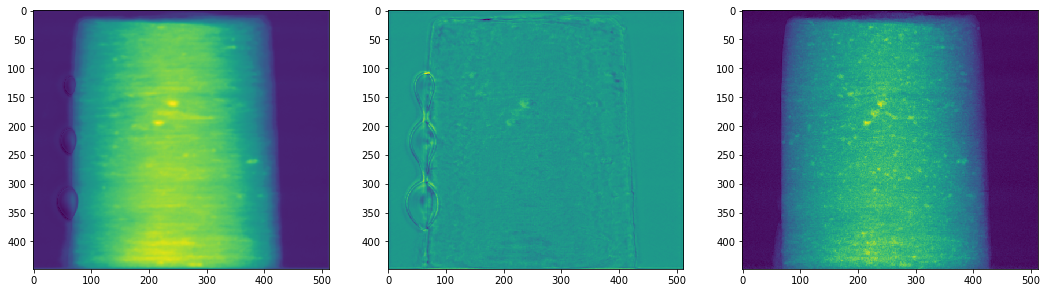

In [19]:
y_dec, y_lat = model.forward(x_prj)
y_dec = to_numpy(y_dec)[0]
y_lat = to_numpy(y_lat)[0, 0]
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(y_dec[y_dec.shape[0] // 2])
axes[1].imshow(y_lat)
axes[2].imshow(prj_trans[prj_trans.shape[0] // 2])
dxchange.write_tiff(y_dec, 'unet/y_dec', dtype='float32', overwrite=True)
dxchange.write_tiff(y_lat, 'unet/y_lat', dtype='float32', overwrite=True)
dxchange.write_tiff(prj_trans, 'unet/x_prj', dtype='float32', overwrite=True)